# AlexNet

* 2012년 ILSVRC 우승 모델 / error_rate:17%
* 5 Convolution_Layey + 3 Fully_Connected_Layer
* Local Response Normalization (Batch Normalization와 유사)
* Overlapping Pooling(X)
* Dropout(0.5)
* Data Augmentation(x)  
* activation_function = ReLU
* loss_function = Cross_Entropy
* optimizer = Adam

* 약 390만개의 parameter

## Mount Google Drive

In [1]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Import Library

In [2]:
# Data
import numpy as np
import pandas as pd

# Preprcessing

# Model
import tensorflow as tf
from tensorflow.keras import Sequential, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Visualizatoin
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Env
import os

## GPU Setting

In [3]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper parameters

In [4]:
#Colab

#Server
DATA_DIR='../data/'
SAVE_DIR='../model/AlexNet/'
LOAD_DIR='../model/AlexNet/'

#Local
# DATA_DIR='C:/Users/is910/Desktop/MNIST/data/'
# SAVE_DIR='C:/Users/is910/Desktop/MNIST/model/AlexNet/'
# LOAD_DIR='C:/Users/is910/Desktop/MNIST/model/AlexNet/'

#Hyper parameter
BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=100
VERBOSE=1
PATIENCE=5
VALIDATION_SPLIT=0.2
EPOCHS=20

## Load data

In [5]:
raw_mnist = tf.keras.datasets.mnist

In [6]:
(X_train_raw, y_train), (X_test_raw, y_test) = raw_mnist.load_data()

In [7]:
np.info(X_train_raw)

class:  ndarray
shape:  (60000, 28, 28)
strides:  (784, 28, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x23700003040
byteorder:  little
byteswap:  False
type: uint8


train 개수

In [8]:
print(X_train_raw.shape)

(60000, 28, 28)


test 개수

In [9]:
print(X_test_raw.shape)

(10000, 28, 28)


In [10]:
print(y_train.shape)

(60000,)


### Matplotlib Image

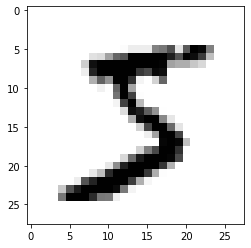

In [11]:
plt.imshow(X_train_raw[0], cmap='gray_r', interpolation='nearest')
plt.show()

### PIL Image

In [12]:
# pil_image = Image.fromarray(X_train_raw[0])
# pil_image.show()

## Preprocessing

### Numpy to Tensor

In [13]:
X_train_tensor = tf.convert_to_tensor(X_train_raw)
X_test_tensor = tf.convert_to_tensor(X_test_raw)

In [14]:
X_train_tensor.shape

TensorShape([60000, 28, 28])

### Reshape Tensor

In [15]:
X_train_reshape_tensor=tf.reshape(X_train_tensor, [60000, 28, 28, -1])
X_test_reshape_tensor=tf.reshape(X_test_tensor, [10000, 28, 28, -1])
#X_train=X_train_reshape_tensor.reshape((60000, 28, 28, -1))

In [16]:
X_train_reshape_tensor.shape

TensorShape([60000, 28, 28, 1])

### Min-Max Scaling

In [17]:
X_train_scaled, X_test_scaled = X_train_reshape_tensor/255, X_test_reshape_tensor/255

In [18]:
X_train_scaled.shape

TensorShape([60000, 28, 28, 1])

In [20]:
X_train, X_test = X_train_scaled, X_test_scaled

In [21]:
X_train.shape

TensorShape([60000, 28, 28, 1])

In [22]:
X_train[0].shape

TensorShape([28, 28, 1])

MNIST 데이터를 AlexNet에 사용하기 위해 Image Resizing을 해주려고 했으나 gpu메모리 부족 이슈가 발생하여 MNIST 데이터의 28x28 이미지를 그대로 인풋으로 사용하기로 했다. 따라서 이미지 크기에 맞게 기존의 AlexNet 모델의 구조에 약간 변형을 가해주었다.

In [46]:
# X_train_resize = tf.image.resize(X_train_scaled, [227, 227], antialias=True)
# X_test_resize = tf.image.resize(X_test_scaled, [227, 227], antialias=True)
# X_train_resize[0].shape

## Model definition
### AlexNet

Functional API

In [23]:
def AlexNet():
    # inputs = tf.keras.Input(X_train[0].shape)
    inputs = tf.keras.Input(shape=(28, 28, 1))
    
    # first convolution layer
    conv_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=1, padding='valid', activation=activations.relu)(inputs)
    pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)
    norm_1 = tf.nn.local_response_normalization(pool_1, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # second convolution layer
    conv_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)(norm_1)
    pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)
    norm_2 = tf.nn.local_response_normalization(pool_2, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # third convolution layer
    conv_3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)(norm_2)

    # fourth convolution layer
    conv_4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)(conv_3)

    # fifth convolution layer
    conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)(conv_4)
    pool_5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_5)
    norm_5 = tf.nn.local_response_normalization(pool_5, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # fully connected layer
    flatten = tf.keras.layers.Flatten()(norm_5) # 2304
    dense_1 = tf.keras.layers.Dense(units=512, activation=activations.relu)(flatten)
    dropout_1 = tf.keras.layers.Dropout(rate=0.5)(dense_1)
    dense_2 = tf.keras.layers.Dense(units=128, activation=activations.relu)(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(rate=0.5)(dense_2)
    outputs = tf.keras.layers.Dense(units=10, activation=activations.softmax)(dropout_2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Model Summary

In [24]:
model = AlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 18, 18, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 96)         0         
 )                                                               
                                                                 
 tf.nn.local_response_normal  (None, 9, 9, 96)         0         
 ization (TFOpLambda)                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 256)        0     

In [25]:
# Subclassing 실패?
# Functional API로 구현된 모델을 subclassing으로 구현하는 방법은?


# inputs = X_train[0].shape

# class AlexNet(tf.keras.layers.Layer):
#     def __init__(self):
#         super(AlexNet, self).__init__()

#         # Initialize first convolution layer
#         self.conv_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=1, padding='valid', activation=activations.relu)
#         self.pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)
#         self.norm_1 = tf.nn.local_response_normalization(self.pool_1, depth_radius=5, bias=1, alpha=1, beta=0.5)

#         # Initialize second convolution layer
#         self.conv_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)
#         self.pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)
#         self.norm_2 = tf.nn.local_response_normalization(self.pool_2, depth_radius=5, bias=1, alpha=1, beta=0.5)

#         # Initialize third convolution layer
#         self.conv_3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)

#         # Initialize fourth convolution layer
#         self.conv_4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)
        
#         # Initialize fifth convolution layer
#         self.conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)
#         self.pool_5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)
#         self.norm_5 = tf.nn.local_response_normalization(self.pool_5, depth_radius=5, bias=1, alpha=1, beta=0.5)
        
#         # Initialize fully connected layer
#         self.flatten = tf.keras.layers.Flatten() # 2304
#         self.dense_1 = tf.keras.layers.Dense(units=512, activation=activations.relu)
#         self.dropout_1 = tf.keras.layers.Dropout(rate=0.5)
#         self.dense_2 = tf.keras.layers.Dense(units=128, activation=activations.relu)
#         self.dropout_2 = tf.keras.layers.Dropout(rate=0.5)
#         self.dense_3 = tf.keras.layers.Dense(units=10, activation=activations.softmax)
        
#     def call(self, x):
#         x = self.conv_1(x)
#         x = self.pool_1(x)
#         x = self.norm_1(x)

#         x = self.conv_2(x)
#         x = self.pool_2(x)
#         x = self.norm_2(x)

#         x = self.conv_3(x)

#         x = self.conv_4(x)

#         x = self.conv_5(x)
#         x = self.pool_5(x)
#         x = self.norm_5(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = self.dropout_1(x)
#         x = self.dense_2(x)
#         x = self.dropout_2(x)
#         x = self.dense_3(x)

#         return x

In [26]:
# Sequentail API 불가능

# input shape
# INPUT_SHAPE=X_train[0].shape

# model=tf.keras.Sequential([
#     # 28*28*1
#     # first convolution layer
#     tf.keras.layers.Conv2D(
#         filters=96, kernel_size=11, strides=1, padding='valid', activation=activations.relu, input_shape=INPUT_SHAPE
#     ), # 18*18*96
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2), # 9*9*96
    
#     # second convolution layer
#     tf.keras.layers.Conv2D(
#         filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu
#     ), # 9*9*256
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'), # 5*5*256
    
#     # third convolution layer
#     tf.keras.layers.Conv2D(
#         filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu
#     ), # 5*5*384
    
#     # fourth convolution layer
#     tf.keras.layers.Conv2D(
#         filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu
#     ), # 5*5*384
    
#     # fifth convolution layer
#     tf.keras.layers.Conv2D(
#         filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu
#     ), # 5*5*256
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'), # 3*3*256

#     # fully connected layer
#     tf.keras.layers.Flatten(), # 2304
#     tf.keras.layers.Dense(units=512, activation=activations.relu),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(units=128, activation=activations.relu),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(units=10, activation='softmax')
# ])

## Model Compile

In [27]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR+'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 18, 18, 96)        11712     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 9, 9, 96)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 9, 9, 256)         221440    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 5, 384)         885120    
                                                                 
 conv2d_23 (Conv2D)          (None, 5, 5, 384)        

In [28]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR+'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [29]:
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[es, mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/20
749/750 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8817
Epoch 1: val_accuracy improved from -inf to 0.97683, saving model to ../model/AlexNet\best-model.h5
750/750 [==============================] - 19s 18ms/step - loss: 0.3688 - accuracy: 0.8818 - val_loss: 0.0826 - val_accuracy: 0.9768
Epoch 2/20
749/750 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9791
Epoch 2: val_accuracy improved from 0.97683 to 0.98625, saving model to ../model/AlexNet\best-model.h5
750/750 [==============================] - 13s 18ms/step - loss: 0.0888 - accuracy: 0.9790 - val_loss: 0.0558 - val_accuracy: 0.9862
Epoch 3/20
749/750 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9840
Epoch 3: val_accuracy improved from 0.98625 to 0.98733, saving model to ../model/AlexNet\best-model.h5
750/750 [==============================] - 13s 18ms/step - loss: 0.0688 - accuracy: 0.9840 - val_loss: 0.0481 - val_accuracy: 0.9873
Epoch 4

## Test Model

In [30]:
loaded_model = load_model(SAVE_DIR+'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.0451 - accuracy: 0.9914
Test loss: 0.045096591114997864
Test accuracy: 0.9914000034332275


## Save Model

In [31]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ../model/AlexNet/trained-model.h5 


## Evaluation

### Loss / Accuracy

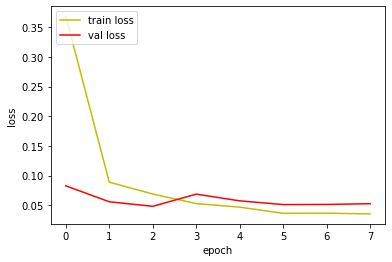

In [32]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

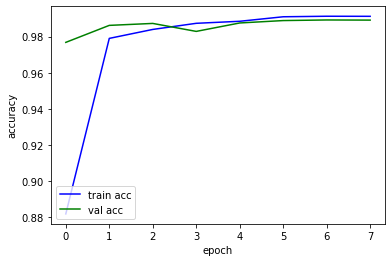

In [33]:
fig, acc_ax = plt.subplots()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

acc_ax.legend(loc='lower left')

plt.show()

In [34]:
# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()


### Confusion matrix

In [35]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

313/313 [==============================] - 1s 4ms/step
[7 2 1 ... 4 5 6]


[[ 975    0    0    0    0    2    1    2    0    0]
 [   3 1127    0    2    1    0    0    2    0    0]
 [   1    2 1023    1    0    0    0    4    1    0]
 [   0    0    0 1001    0    7    0    1    1    0]
 [   0    0    0    0  978    0    0    0    0    4]
 [   0    0    0    2    0  888    1    1    0    0]
 [   2    3    0    0    3    2  948    0    0    0]
 [   0    3    1    0    0    0    0 1022    0    2]
 [   3    0    2    2    0    7    0    2  956    2]
 [   0    0    0    0    5    2    0    5    1  996]]


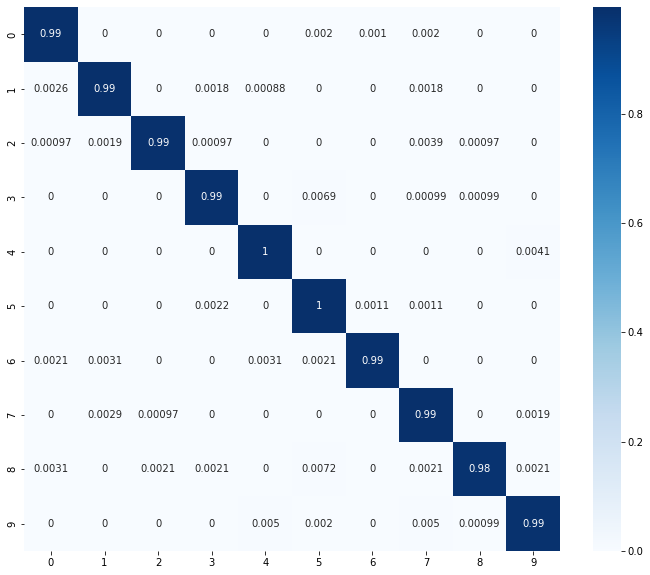

In [36]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(10, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + 'output.png')

### precision, recall, f1 score

In [37]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score_s = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score_s)

accuracy_score:  0.9914
precision_score:  0.9913228270902772
recall_score:  0.9914020529366562
f1_score:  0.9913415338185736


## Load Model

In [38]:
model_name='trained-model.h5'
model_path=os.path.join(LOAD_DIR, model_name)
model=load_model(model_path)

## Predict

In [39]:
print(X_train.shape, X_train[0].shape, sep='\n')

(60000, 28, 28, 1)
(28, 28, 1)


In [40]:
def predict_mnist(tensor, model):
    sample=tf.reshape(tensor, [-1, 28, 28])
    result_prob=model.predict(sample, verbose=0)
    result=np.argmax(result_prob)
    print(result)

5 클래스에 대한 예측

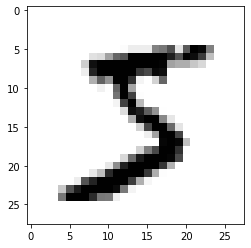

In [41]:
plt.imshow(X_train[0], cmap='gray_r', interpolation='nearest')
plt.show()

In [42]:
predict_mnist(X_train[0], model)

5


 0 클래스에 대한 예측

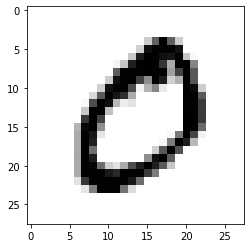

In [43]:
plt.imshow(X_train[1], cmap='gray_r', interpolation='nearest')
plt.show()

In [44]:
predict_mnist(X_train[1], model)

0
